In [1]:
from _shgo import *

In [2]:
def f(x):  # Alpine2
    prod = 1
    for i in range(numpy.shape(x)[0]):
        prod = prod * numpy.sqrt(x[i]) * numpy.sin(x[i])

    return prod

bounds = [(0, 5), (0, 5)]
n = 10

In [3]:
SHc = SHGO(f, bounds, n = n)

In [4]:
SHc.construct_complex_sobol()

In [5]:
# Minimise the pool of minisers with local minimisation methods
SHc.minimise_pool()

In [6]:
# Sort results and build the global return object
SHc.sort_result()

In [7]:
#res = shgo(f, bounds)

<IPython.core.display.Javascript object>


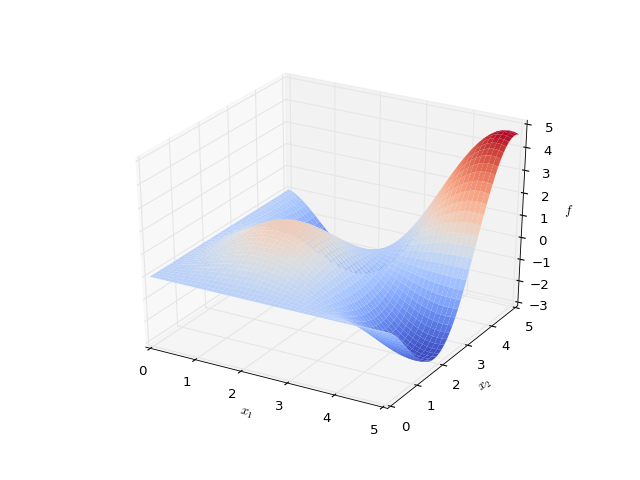

<IPython.core.display.Javascript object>


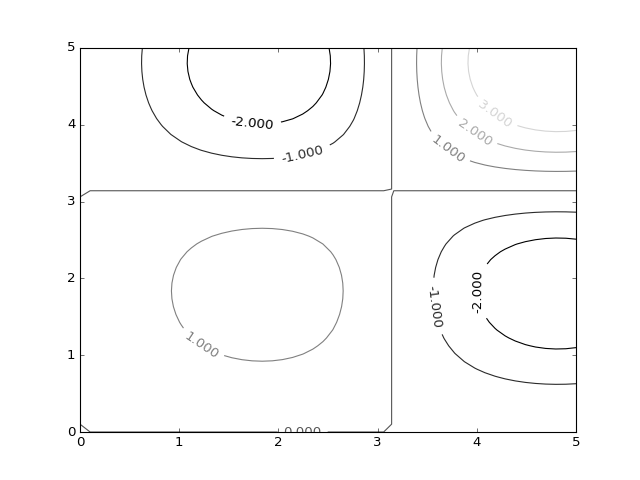

In [9]:
%matplotlib nbagg

import matplotlib.pyplot as plt
def build_contour(SHc, surface=True, contour=True):
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    from matplotlib import cm

    X = SHc.C[:, 0]
    X = numpy.linspace(SHc.bounds[0][0], SHc.bounds[0][1])
    Y = SHc.C[:, 1]
    Y = numpy.linspace(SHc.bounds[1][0], SHc.bounds[1][1])
    xg, yg = numpy.meshgrid(X, Y)
    Z = numpy.zeros((xg.shape[0],
                     yg.shape[0]))

    for i in range(xg.shape[0]):
        for j in range(yg.shape[0]):
            Z[i, j] = SHc.func([xg[i, j], yg[i, j]])

    if surface:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(xg, yg, Z, rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0,
                        antialiased=True, alpha=1.0, shade=True)
        if False:
            cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
            cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
            cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel('$f$')
        
    if contour:  
        plt.figure()
        cs = plt.contour(xg, yg, Z, cmap='binary_r')
        plt.clabel(cs)

build_contour(SHc)
plt.show()


In [56]:
def direct_2d(ax, func, V1, V2, vertex_plot_size=0.00):
    """Draw a directed graph arrow between two vertices"""
    import numpy
    
    # NOTE: Can retrieve from stored class
    f_1 = func(V1)
    f_2 = func(V2)

    def vertex_diff(V_low, V_high, vertex_plot_size):
        # Note assumes bounds in R+ (0, inf)
        dV = [0, 0]
        for i in [0, 1]:
            if V_low[i] < V_high[i]:
                dV[i] = -(V_high[i] - V_low[i]) #+ vertex_plot_size
            else:
                dV[i] = V_low[i] - V_high[i]  #- vertex_plot_size

            if dV[i] > 0:
                dV[i] -= vertex_plot_size
            else:
                dV[i] += vertex_plot_size

        return dV

    if f_1 < f_2:  # direct V2 --> V1
        dV = vertex_diff(V1, V2, vertex_plot_size)
        dV = 0.50 * numpy.array(dV)
        #print(dV)        
        ax.arrow(V2[0], V2[1], dV[0], dV[1], head_width=0.05, head_length=0.3, fc='k', ec='k', color='k')

    elif f_1 > f_2:  # direct V1 --> V2
        pass
    
    return f_1, f_2 #TEMPORARY USE IN LOOP

<IPython.core.display.Javascript object>


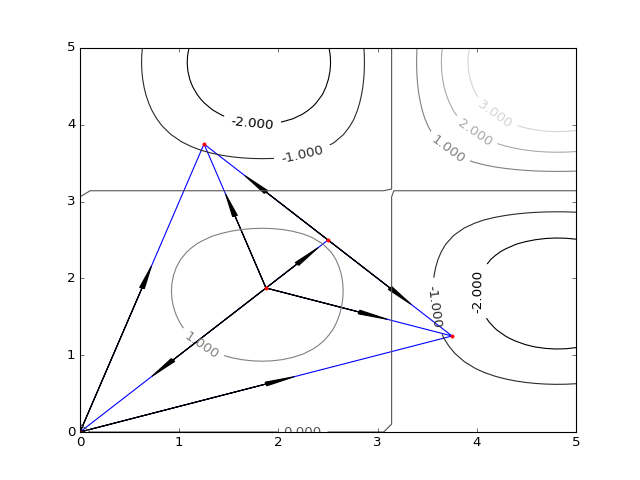

Incidence Array:
[[-1. -1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  1.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [57]:
%matplotlib nbagg
from ipywidgets import interact

def build_complex(n, lb1=0, lb2=0, ub1=5, ub2=5):
    import numpy
    bounds=[(lb1, ub1), (lb2, ub2)]
    SHc = SHGO(f, bounds, n = n)
    SHc.construct_complex_sobol()
    SHc.minimise_pool()
    SHc.sort_result()
    
    import matplotlib.pyplot as plt
    from scipy.spatial import Delaunay
    #plt.figure()
    
    points = SHc.C
    tri = Delaunay(points)
    
    # Label edges
    edges = numpy.array(tri.simplices)#numpy.zeros(len(tri.simplices))
    constructed_edges = []
    incidence_array = numpy.zeros([numpy.shape(points)[0], numpy.shape(edges)[0]])
    
    # contour
    build_contour(SHc, surface=False, contour=True)

    # graph
    plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
    plt.plot(points[:, 0], points[:, 1], '.')

    # directed
    ax = plt.axes()
    for i in range(points.shape[0]):
        for i2 in SHc.find_neighbors(i, SHc.Tri):
            # Draw arrow
            f_1, f_2 = direct_2d(ax, f, SHc.Tri.points[i, :], SHc.Tri.points[i2, :])
            
            # Find incidence on an edge
            for edge, e in zip(edges, range(numpy.shape(edges)[0])):
                #print(edge)
                if e not in constructed_edges:
                    if i in edge:
                        if f_1 < f_2:
                            incidence_array[i, e] += 1
                        elif  f_1 > f_2: 
                            incidence_array[i, e] -= 1
                    if i2 in edge:
                        if f_2 < f_1:
                            incidence_array[i2, e] += 1
                        elif f_2 > f_1: 
                            incidence_array[i2, e] -= 1
                            
                    constructed_edges.append(e)
                
            #f_1 = func(V1)
            #f_2 = func(V2)


    
    #print(tri.simplices)
    #print(len(tri.simplices))

    #find_neighbors(i)
    print('Incidence Array:')
    print(incidence_array)
    
interact(build_complex, n=(5, 100), lb1=(-100, 100), lb2=(-100, 100), ub1=(-45, 55), ub2=(-45, 55))



In [58]:
#help(ax.arrow)

In [49]:
SHc.Tri

In [55]:
# neighbor_indices = find_neighbors(0, tri)
neighbor_indices = SHc.find_neighbors(0, SHc.Tri)
print('neighbor_indices = find_neighbors(0, tri)'
      ' = {}'.format(neighbor_indices))
print('points[neighbor_indices] = '
      '{}'.format(points[neighbor_indices]))
print('SHGO.C [neighbor_indices] '
      '= {}'.format(SHc.C[neighbor_indices]))

neighbor_indices = find_neighbors(0, tri) = [8 7 6]


NameError: name 'points' is not defined